<a href="https://colab.research.google.com/github/rn-kay99/Notebooks/blob/main/prediction/prediction_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hands-On Exercise: Predictive Monitoring

In this exercise, you will take up the real-world event log of a process to manage road traffic fines, introduced already in an earlier exercise. The following text gives some further details on this log, quoted from Mannhardt et al. (Computing, 2016):

_The road traffic fine management process is supported by an information system that records data about its operations in a PostgresSQL database. The database snapshot used here was taken in June 2013. We exported the event log to a CSV format and converted it to the XES format […]. From the analysis of the event log, we noticed that cases are usually completed within 6 months, including those cases ending with a referral to credit collection. For the analysis, we want to consider only finished cases. As a heuristic to ensure this, we filtered out any case that started after June 2012. Since the relevant laws and procedures are rather stable over the past years, the last year of the event log should show the same behavior as in previous years. The resulting event log contains 145,800 event traces, which were recorded between January 2000 and June 2012._

The event log comes with this notebook but can also be downloaded (XES format, please unzip) [here](https://data.4tu.nl/repository/uuid:270fd440-1057-4fb9-89a9-b699b47990f5).

In [ ]:
# show plots in better quality
%config InlineBackend.figure_format = 'svg'

# import data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

# direct data upload
#from google.colab import files
#files.upload()

# fetch the data file
! wget -O traffic.xes.gz https://github.com/matthiasweidlich/promi_course/blob/master/prediction/traffic.xes.gz?raw=true

# unzip the data file
! gzip -d traffic.xes.gz

## Import Event Log
The following method imports the log file and returns it in a list structure.

In [29]:
import xml.etree.ElementTree as et

def load_xes(file, event_filter=[]):
    log = []

    tree = et.parse(file)
    data = tree.getroot()

    # find all traces
    traces = data.findall('{http://www.xes-standard.org/}trace')

    for t in traces:
        trace_id = None

        # get trace id
        for a in t.findall('{http://www.xes-standard.org/}string'):
            if a.attrib['key'] == 'concept:name':
                trace_id = a.attrib['value']

        events = []
        # events
        for event in t.iter('{http://www.xes-standard.org/}event'):

            e = {'name': None, 'timestamp': None, 'resource': None, 'transition': None,
                 'amount': None, 'dismissal': None, 'vehicleClass': None, 'totalPaymentAmount': None,
                 'article': None, 'points': None, 'expense': None, 'notificationType': None, 'lastSent': None}

            for a in event:
                key = a.attrib['key']
                if ':' in key:
                    key = key.split(':')[1]
                e[key] = a.attrib['value']

            if e['name'] in event_filter or len(event_filter) == 0:
                events.append(e)

        # add trace to log
        if len(events) > 0:
            log.append({'trace_id': trace_id, 'events': events})
    return log

Now import the given log and compute the trace variants of the log along with their frequencies.

In [30]:
from pprint import pprint

log_file = './traffic.xes'
log = load_xes(log_file)

print('Load log with %s traces.' %len(log))

trace_variants = {}
for trace in log:
    events = []
    for event in trace['events']:
        events.append(event['name'])
    trace_variants[tuple(events)] = trace_variants.get(tuple(events), 0) + 1

# print the two most frequent variants
trace_variants_sorted_by_freq = sorted(trace_variants.items(), key=lambda kv: kv[1], reverse=True)
pprint(trace_variants_sorted_by_freq[:2])

Load log with 150370 traces.
[(('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Send for Credit Collection'),
  56482),
 (('Create Fine', 'Payment'), 46371)]


## Task: Feature and Label Extraction
The following function takes the event log as input and needs to derive the feature vectors per trace and the label per trace for one of the LTL queries given in the exercise sheet. Complete the respective code.

In [33]:
def extract_features_and_labels(log, feature_keys):
    labels = []
    features = []

    for trace in log:
        trace_truth_value = True
        has_appeal_to_judge = False
        trace_features = []

        ############################################
        # Your code here to
        #  - identify whether the trace satisfies the query
        #    (Take a simplistic approach. Do not derive a
        #     Kripke structure, but simply scan the trace
        #     sequentially to decide whether a constraint
        #     of the form G(x => F(y)) is satisfied)
        #  - collect all the features from each trace,
        #    such that features is a list of lists, e.g.,
        #    [["A", 2],["B", 8], ["A", 6]] for three traces
        #    that have two features each
        ############################################

        for event in trace['events']:
          # set label
          if event['name'] == 'Appeal to Judge':
            trace_truth_value = False
            has_appeal_to_judge = True
          elif event['name'] == 'Add penalty' and has_appeal_to_judge:
            trace_truth_value = True

            # set feature vector
            for feature in feature_keys:
              if feature in event:
                trace_features.append(event[feature])

        features.append(trace_features)


        if trace_truth_value:
            labels.append(1)
        else:
            labels.append(0)

    return features, labels


# The features to consider
feature_keys = ['resource', 'amount', 'dismissal', 'vehicleClass', 'totalPaymentAmount', 'article', 'points', 'expense', 'notificationType', 'lastSent']

# Call the method to extract features and labels
features, labels = extract_features_and_labels(log, feature_keys)

# Do some post-processing to encode categorical variables
import pandas as pd
features_tmp = pd.DataFrame(features, columns=feature_keys)
# Those are the numeric variables
features_df = features_tmp[['amount', 'totalPaymentAmount', 'article', 'points', 'expense']]
# Apply a one-hot-encoding for the categorical variables
features_df = pd.concat((features_df, pd.get_dummies(features_tmp.resource, prefix="resource")), axis=1)
features_df = pd.concat((features_df, pd.get_dummies(features_tmp.dismissal, prefix="dismissal")), axis=1)
features_df = pd.concat((features_df, pd.get_dummies(features_tmp.vehicleClass, prefix="vehicleClass")), axis=1)
features_df = pd.concat((features_df, pd.get_dummies(features_tmp.notificationType, prefix="notificationType")), axis=1)
features_df = pd.concat((features_df, pd.get_dummies(features_tmp.lastSent, prefix="lastSent")), axis=1)

pprint(features_df)


       amount totalPaymentAmount article points expense
0        None               None    None   None    None
1        None               None    None   None    None
2        None               None    None   None    None
3        None               None    None   None    None
4        None               None    None   None    None
...       ...                ...     ...    ...     ...
150365   None               None    None   None    None
150366   None               None    None   None    None
150367   None               None    None   None    None
150368   None               None    None   None    None
150369   None               None    None   None    None

[150370 rows x 5 columns]


## Learn the Prediction Model
The code below learns a decision tree from the extracted features and labels. Explore the resulting tree.

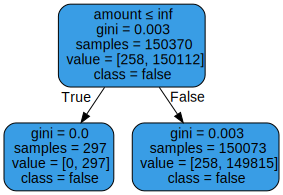

In [34]:
from sklearn import tree
import graphviz

# Learn a decision tree
clf = tree.DecisionTreeClassifier(max_depth=3)
if not features_df.empty:
  clf = clf.fit(features_df, labels)

  # Render the obtained decision tree
  dot_data = tree.export_graphviz(
    clf, out_file=None, feature_names=list(features_df), class_names=['true', 'false'],
    filled=True, rounded=True, special_characters=True)
  graph = graphviz.Source(dot_data)
  display(graph)